In [1]:
import load


The data is composed of 136 features and  1 524 098 samples (the whole csv is 1GB which is too large for my computer)

To import the dataset, call load(raw=True, samples=N) to have raw and False to have cleaned
        raw = True to load raw data, False to load cleaned data
        samples = N to load only N lines, -1 to load all



In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

In [220]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

In [189]:
basefigsize = (10, 7)

### Load data


In [190]:
df_partial_initial = load.load(raw=True, samples=20000)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (122,123,124,127,128,129,132) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [191]:
df_partial = df_partial_initial.reset_index()
df_partial.head()

id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 NaN        NaN    12000.0      12000.0          12000.0   36 months   
1 NaN        NaN    11500.0      11500.0          11500.0   60 months   
2 NaN        NaN    15000.0      15000.0          15000.0   36 months   
3 NaN        NaN    24000.0      24000.0          24000.0   36 months   
4 NaN        NaN    12000.0      12000.0          12000.0   36 months   

   int_rate  installment grade sub_grade             ...               \
0      6.62       368.45     A        A2             ...                
1     22.90       323.54     E        E4             ...                
2      8.90       476.30     A        A5             ...                
3     13.53       814.80     B        B5             ...                
4     13.53       407.40     B        B5             ...                

  hardship_amount hardship_start_date hardship_end_date  \
0             NaN                 NaN               NaN   
1             NaN                 NaN               NaN   
2             NaN                 NaN               NaN   
3             NaN                 NaN               NaN   
4             NaN                 NaN               NaN   

   payment_plan_start_date hardship_length hardship_dpd hardship_loan_status  \
0                      NaN             NaN          NaN                  NaN   
1                      NaN             NaN          NaN                  NaN   
2                      NaN             NaN          NaN                  NaN   
3                      NaN             NaN          NaN                  NaN   
4                      NaN             NaN          NaN                  NaN   

  orig_projected_additional_accrued_interest hardship_payoff_balance_amount  \
0                                        NaN                            NaN   
1                                        NaN                            NaN   
2                                        NaN                            NaN   
3                                        NaN                            NaN   
4                                        NaN                            NaN   

  hardship_last_payment_amount  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  

[5 rows x 136 columns]

### Features cleaning

In [192]:
empty_columns = []
for column in df_partial:
    if len(np.unique(df_partial.loc[:, column].dropna())) == 0:
        empty_columns.append(column)
print('There are {} empty columns.'.format(len(empty_columns)))
df_partial = df_partial.loc[:, [column for column in df_partial if column not in empty_columns]]

unique_columns = []
for column in df_partial:
    if len(np.unique(df_partial.loc[:, column].dropna())) == 1:
        unique_columns.append(column)
print('There are {} columns with only one value.'.format(len(unique_columns)))
df_partial = df_partial.loc[:, [column for column in df_partial if column not in unique_columns]]

There are 30 empty columns.
There are 5 columns with only one value.


### Missing data overview

Missing data per feature: 

`hardship_*` features have few occurrences. Same for `mths_*` and `desc`. Rest looks legit.

In [193]:
(df_partial.isnull().sum(axis = 0) / len(df_partial)).sort_values(ascending = False)

orig_projected_additional_accrued_interest    0.99960
hardship_last_payment_amount                  0.99955
hardship_start_date                           0.99955
hardship_reason                               0.99955
hardship_payoff_balance_amount                0.99955
hardship_amount                               0.99955
hardship_status                               0.99955
hardship_end_date                             0.99955
payment_plan_start_date                       0.99955
hardship_dpd                                  0.99955
hardship_loan_status                          0.99955
next_pymnt_d                                  0.92125
mths_since_last_record                        0.86960
mths_since_last_major_derog                   0.77575
mths_since_recent_bc_dlq                      0.75210
desc                                          0.69440
mths_since_recent_revol_delinq                0.66890
mths_since_last_delinq                        0.52970
mths_since_recent_inq       

Missing data per sample

In [194]:
(df_partial.isnull().sum(axis = 1) / len(df_partial.columns)).sort_values(ascending = False)

11502    0.227723
15627    0.227723
19207    0.227723
8043     0.227723
2076     0.227723
9360     0.227723
11064    0.217822
18473    0.217822
3798     0.217822
8132     0.217822
363      0.217822
12084    0.217822
5850     0.217822
3486     0.217822
4053     0.217822
13489    0.217822
10105    0.217822
5498     0.217822
13329    0.217822
12174    0.217822
13285    0.217822
18202    0.217822
11724    0.217822
16575    0.217822
12330    0.217822
19782    0.217822
2378     0.217822
12029    0.217822
15988    0.217822
10240    0.217822
           ...   
6805     0.118812
18752    0.118812
7843     0.118812
11914    0.118812
6755     0.118812
146      0.118812
3695     0.118812
17468    0.118812
6784     0.118812
18219    0.118812
11678    0.118812
15712    0.118812
10582    0.118812
6172     0.118812
15147    0.118812
11525    0.118812
15703    0.118812
4552     0.108911
13264    0.108911
128      0.108911
5185     0.108911
3106     0.059406
3224     0.059406
3797     0.049505
6114     0

### Feature distributions

In [241]:
def plot_distribution_discrete(feature_data, column_name):
    feature_data = feature_data.dropna()
    unique_values = list(set(feature_data))
    if len(unique_values) > 36:
        print("There are {} unique values on discrete column {}, such as '{}', '{}', '{}'.".format(len(set(feature_data)),
                                                                                                  column_name,
                                                                                                  unique_values[0],
                                                                                                  unique_values[1],
                                                                                                  unique_values[2]),
             "\n")
        return 
    plt.figure(figsize=basefigsize)
    unique_values = np.unique(feature_data)
    ax = sns.countplot(feature_data, order=sorted(unique_values, 
                                             key = lambda val: (feature_data == val).sum(), 
                                             reverse = True))
    plt.title("Feature `{}` distribution".format(column_name))
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.4f}'.format(height / len(feature_data)),
                ha="center") 
    
    plt.show()
    return ax

In [242]:
def plot_distribution_continuous(feature_data, column_name):
    feature_data = feature_data.dropna()
    plt.figure(figsize=basefigsize)
    sns.distplot(feature_data, bins = 30)
    plt.title("Feature `{}` distribution".format(column_name))
    plt.show()

Distribution of feature loan_amnt.


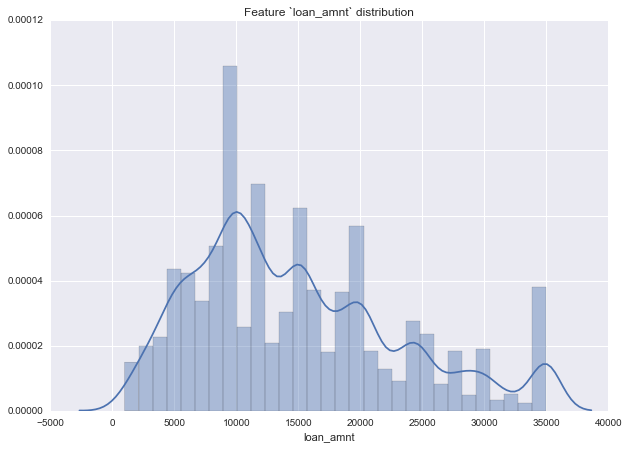

Distribution of feature funded_amnt.


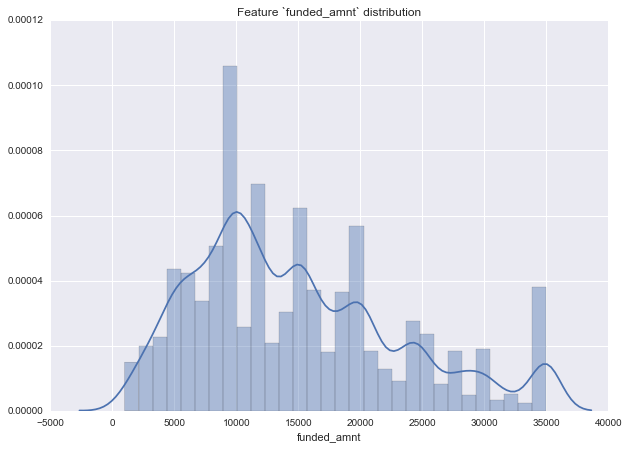

Distribution of feature funded_amnt_inv.


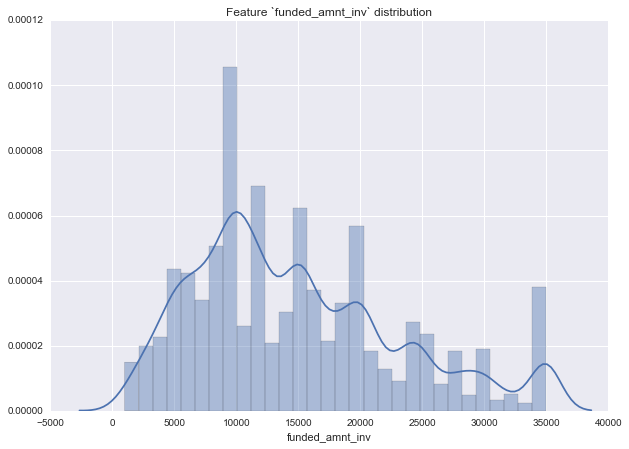

Distribution of feature term.


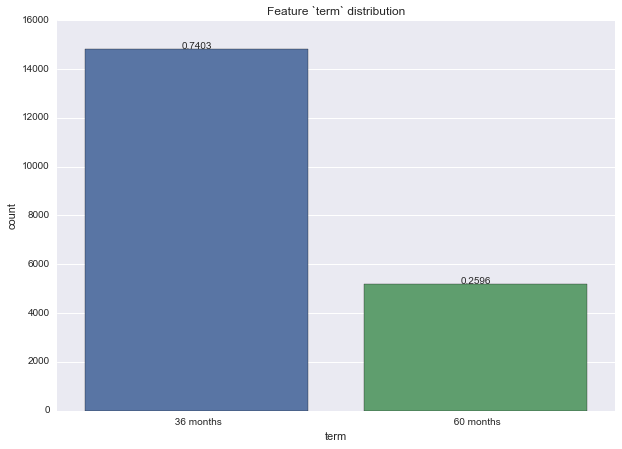

Distribution of feature int_rate.


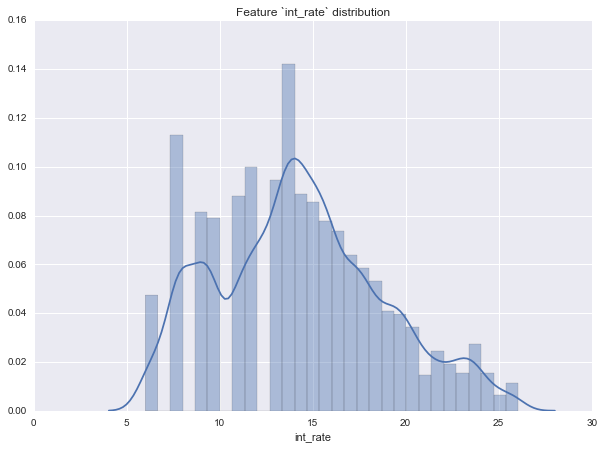

Distribution of feature installment.


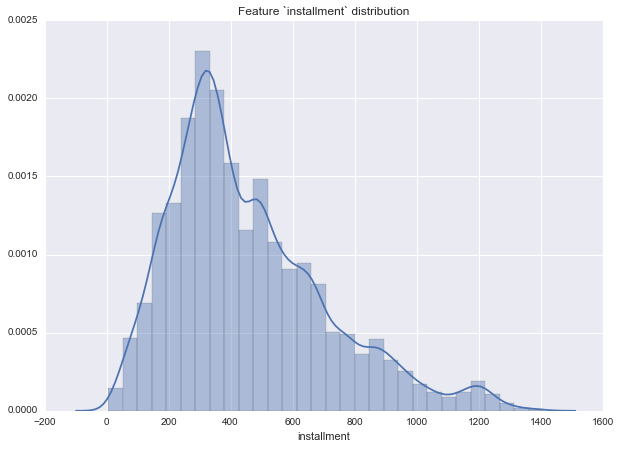

Distribution of feature grade.


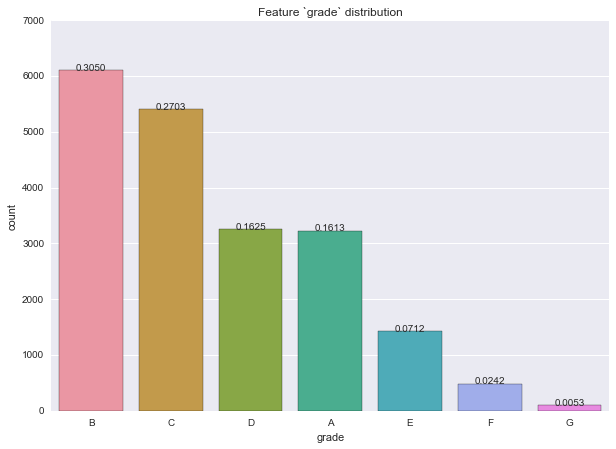

Distribution of feature sub_grade.


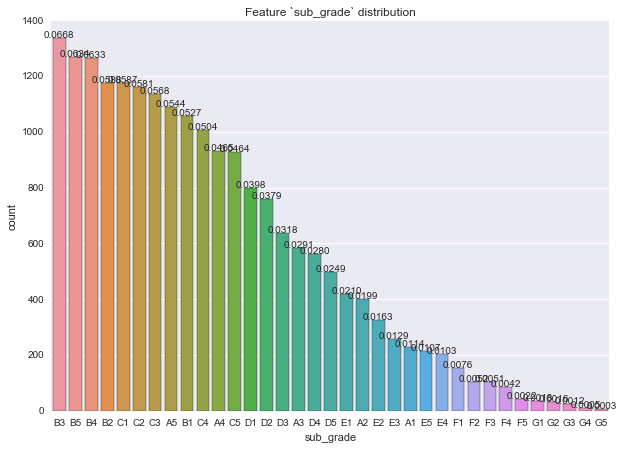

Distribution of feature emp_title.
There are 10051 unique values on discrete column emp_title, such as 'Human Resources Generalist', 'Federal Programs Director', 'Office Specialist'. 

Distribution of feature emp_length.


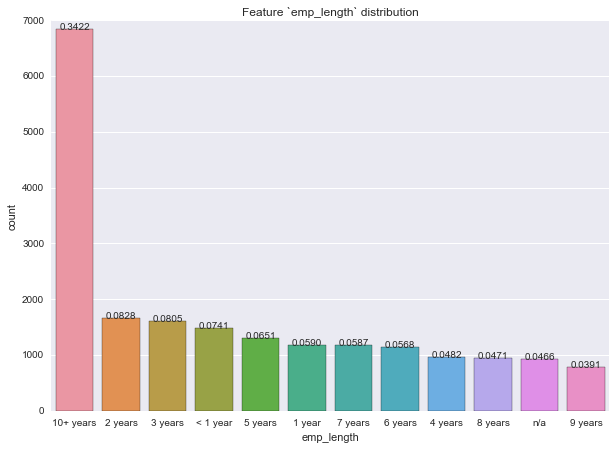

In [243]:
messy_columns = []
for column in df_partial.columns[:10]:
    print("Distribution of feature {}.".format(column))
    try:
        feature_data = df_partial.loc[:, column]
        if feature_data.dtype == np.dtype('O'):
            plot_distribution_discrete(feature_data, column)
        elif feature_data.dtype in [np.dtype('float64'), np.dtype('int64')]:
            plot_distribution_continuous(feature_data, column)

    except TypeError as e:
        print(e, "on column {}.".format(column))
        messy_columns.append(column)

### Target function

The target column is `loan_status`.

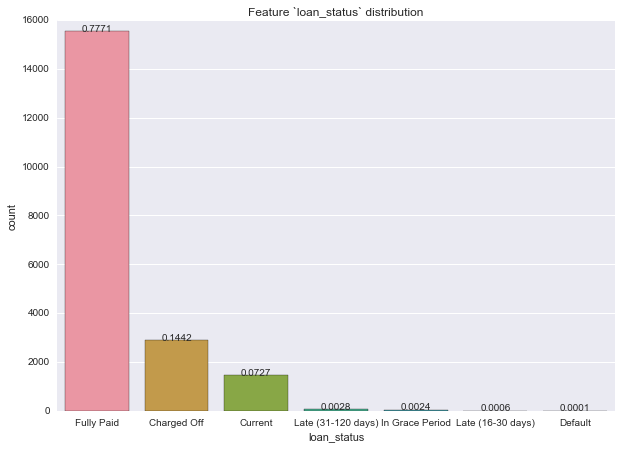

In [200]:
plot_distribution_discrete(df_partial.loc[:, 'loan_status'], 'loan_status')

In [201]:
target = df_partial.loc[:, 'loan_status'] != "Fully Paid"

### Raw predictive power 

In [221]:
def predict_univariate_continuous(feature_data, target_data):
    lb_target = LabelBinarizer()
    
    X = feature_data.reshape((len(feature_data), 1))
    y = lb_target.fit_transform(target_data)
    y = target_data

    predictor = LogisticRegression()
    predictor.fit(X, y)
    return predictor.score(X, y), mutual_info_regression(X, y)

In [222]:
def predict_univariate_discrete(feature_data, target_data):
    feature_data = feature_data.dropna()
    unique_values = list(set(feature_data))
    if len(unique_values) > 30:
        return

    lb_feature = LabelBinarizer()
    lb_target = LabelBinarizer()
    
    X = lb_feature.fit_transform(feature_data)
    y = lb_target.fit_transform(target_data)

    predictor = BernoulliNB()
    predictor.fit(X, y)
    return predictor.score(X, y), mutual_info_classif(X, y)

In [223]:
def score_univariate(feature_data, target_data):
    if feature_data.dtype == np.dtype('O'):
        return predict_univariate_discrete(feature_data, target_data)
    else:
        return predict_univariate_continuous(feature_data, target_data)

In [236]:
scores = []
for column in tqdm(df_partial.columns):
    try:
        score, mutual_information = score_univariate(df_partial.loc[:, column], target)
        scores.append({'feature' : column, 
                       'score' : score,
                       'mutual_information' : mutual_information[0]})
    except (ValueError, TypeError) as e:
        print("Failed for column {} with error {}".format(column, e))


  0%|          | 0/101 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
  1%|          | 1/101 [00:00<01:28,  1.14it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.

Failed for column sub_grade with error 'NoneType' object is not iterable
Failed for column emp_title with error 'NoneType' object is not iterable


 10%|▉         | 10/101 [00:10<01:51,  1.23s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 11%|█         | 11/101 [00:11<01:42,  1.14s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 12%|█▏        | 12/101 [00:12<01:36,  1.09s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skle

Failed for column desc with error 'NoneType' object is not iterable


 18%|█▊        | 18/101 [00:18<01:25,  1.03s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Failed for column title with error 'NoneType' object is not iterable
Failed for column zip_code with error 'NoneType' object is not iterable
Failed for column addr_state with error 'NoneType' object is not iterable


 22%|██▏       | 22/101 [00:22<01:20,  1.02s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 23%|██▎       | 23/101 [00:23<01:06,  1.17it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
 

Failed for column earliest_cr_line with error 'NoneType' object is not iterable


 25%|██▍       | 25/101 [00:23<00:50,  1.50it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Failed for column mths_since_last_delinq with error Input contains NaN, infinity or a value too large for dtype('float64').
Failed for column mths_since_last_record with error Input contains NaN, infinity or a value too large for dtype('float64').


 28%|██▊       | 28/101 [00:24<00:37,  1.92it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 29%|██▊       | 29/101 [00:24<00:36,  1.99it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
 

Failed for column revol_util with error Input contains NaN, infinity or a value too large for dtype('float64').


 32%|███▏      | 32/101 [00:29<01:21,  1.18s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 33%|███▎      | 33/101 [00:29<01:02,  1.09it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 34%|███▎      | 34/101 [00:29<00:52,  1.28it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipyk

Failed for column last_pymnt_d with error 'NoneType' object is not iterable


 44%|████▎     | 44/101 [00:46<01:13,  1.30s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Failed for column next_pymnt_d with error Found input variables with inconsistent numbers of samples: [1575, 20000]
Failed for column last_credit_pull_d with error 'NoneType' object is not iterable


 47%|████▋     | 47/101 [00:47<00:53,  1.02it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Failed for column mths_since_last_major_derog with error Input contains NaN, infinity or a value too large for dtype('float64').


 49%|████▊     | 49/101 [00:48<00:48,  1.08it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 50%|████▉     | 50/101 [00:50<00:52,  1.03s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
 

Failed for column bc_open_to_buy with error Input contains NaN, infinity or a value too large for dtype('float64').
Failed for column bc_util with error Input contains NaN, infinity or a value too large for dtype('float64').


 56%|█████▋    | 57/101 [01:10<02:01,  2.75s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 57%|█████▋    | 58/101 [01:11<01:29,  2.07s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
 

Failed for column mo_sin_old_il_acct with error Input contains NaN, infinity or a value too large for dtype('float64').


 59%|█████▉    | 60/101 [01:12<01:09,  1.69s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 60%|██████    | 61/101 [01:13<00:55,  1.39s/it]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
 

Failed for column mths_since_recent_bc with error Input contains NaN, infinity or a value too large for dtype('float64').
Failed for column mths_since_recent_bc_dlq with error Input contains NaN, infinity or a value too large for dtype('float64').
Failed for column mths_since_recent_inq with error Input contains NaN, infinity or a value too large for dtype('float64').
Failed for column mths_since_recent_revol_delinq with error Input contains NaN, infinity or a value too large for dtype('float64').


 67%|██████▋   | 68/101 [01:15<00:22,  1.44it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 68%|██████▊   | 69/101 [01:15<00:20,  1.56it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
 

Failed for column num_tl_120dpd_2m with error Input contains NaN, infinity or a value too large for dtype('float64').


 78%|███████▊  | 79/101 [01:20<00:10,  2.12it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 79%|███████▉  | 80/101 [01:20<00:09,  2.13it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
 

Failed for column percent_bc_gt_75 with error Input contains NaN, infinity or a value too large for dtype('float64').


 83%|████████▎ | 84/101 [01:22<00:09,  1.89it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
 84%|████████▍ | 85/101 [01:23<00:08,  1.98it/s]/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype bool was converted to float64 by the scale function.
 

Failed for column hardship_reason with error Found input variables with inconsistent numbers of samples: [9, 20000]
Failed for column hardship_status with error Found input variables with inconsistent numbers of samples: [9, 20000]
Failed for column hardship_amount with error Input contains NaN, infinity or a value too large for dtype('float64').
Failed for column hardship_start_date with error Found input variables with inconsistent numbers of samples: [9, 20000]
Failed for column hardship_end_date with error Found input variables with inconsistent numbers of samples: [9, 20000]
Failed for column payment_plan_start_date with error Found input variables with inconsistent numbers of samples: [9, 20000]
Failed for column hardship_dpd with error Input contains NaN, infinity or a value too large for dtype('float64').
Failed for column hardship_loan_status with error Found input variables with inconsistent numbers of samples: [9, 20000]
Failed for column orig_projected_additional_accrued_in

In [237]:
pd.DataFrame(scores).sort_values('score')

feature  mutual_information    score
4                     int_rate            0.064608  0.77000
0                    loan_amnt            0.020868  0.77705
56                num_tl_30dpd            0.000000  0.77705
55                    num_sats            0.001401  0.77705
32             last_pymnt_amnt            0.289106  0.77705
65  total_il_high_credit_limit            0.000816  0.77705
34              acc_now_delinq            0.000000  0.77705
35                tot_coll_amt            0.000000  0.77705
36                 tot_cur_bal            0.000000  0.77705
37            total_rev_hi_lim            0.002279  0.77705
38        acc_open_past_24mths            0.002042  0.77705
39                 avg_cur_bal            0.000638  0.77705
40    chargeoff_within_12_mths            0.006579  0.77705
41                 delinq_amnt            0.000000  0.77705
42        mo_sin_old_rev_tl_op            0.000000  0.77705
43       mo_sin_rcnt_rev_tl_op            0.000000  0.77705
44              mo_sin_rcnt_tl            0.002361  0.77705
45                    mort_acc            0.001809  0.77705
46       num_accts_ever_120_pd            0.003409  0.77705
47              num_actv_bc_tl            0.000000  0.77705
48             num_actv_rev_tl            0.001977  0.77705
49                 num_bc_sats            0.003259  0.77705
50                   num_bc_tl            0.000000  0.77705
51                   num_il_tl            0.000000  0.77705
52               num_op_rev_tl            0.000000  0.77705
57          num_tl_90g_dpd_24m            0.002433  0.77705
58          num_tl_op_past_12m            0.000000  0.77705
27             total_rec_prncp            0.387543  0.77705
26             total_pymnt_inv            0.048386  0.77705
1                  funded_amnt            0.019679  0.77705
..                         ...                 ...      ...
10         verification_status            0.019023  0.77705
11                     issue_d            0.000000  0.77705
62             tot_hi_cred_lim            0.001986  0.77705
53               num_rev_accts            0.004634  0.77705
61                   tax_liens            0.000000  0.77705
15                         dti            0.001851  0.77705
16                 delinq_2yrs            0.002688  0.77705
17              inq_last_6mths            0.000531  0.77705
18                    open_acc            0.000000  0.77705
19                     pub_rec            0.000000  0.77705
20                   revol_bal            0.002458  0.77705
21                   total_acc            0.000076  0.77705
22         initial_list_status            0.008861  0.77705
60        pub_rec_bankruptcies            0.000000  0.77705
59              pct_tl_nvr_dlq            0.001141  0.77705
25                 total_pymnt            0.056640  0.77705
14                     purpose            0.003788  0.77705
54         num_rev_tl_bal_gt_0            0.002106  0.77705
33  collections_12_mths_ex_med            0.005119  0.77710
13                  pymnt_plan            0.002453  0.77725
66               hardship_flag            0.001487  0.77735
6                        grade            0.018707  0.77770
29          total_rec_late_fee            0.006190  0.77905
3                         term            0.083418  0.78940
28               total_rec_int            0.076667  0.79420
24               out_prncp_inv            0.131478  0.85580
23                   out_prncp            0.129972  0.85580
31     collection_recovery_fee            0.158921  0.87115
30                  recoveries            0.229326  0.89575
12                 loan_status            0.266370  1.00000

[67 rows x 3 columns]

In [239]:
pd.DataFrame(scores).sort_values('mutual_information', ascending = False)

feature  mutual_information    score
27             total_rec_prncp            0.387543  0.77705
32             last_pymnt_amnt            0.289106  0.77705
12                 loan_status            0.266370  1.00000
30                  recoveries            0.229326  0.89575
31     collection_recovery_fee            0.158921  0.87115
24               out_prncp_inv            0.131478  0.85580
23                   out_prncp            0.129972  0.85580
3                         term            0.083418  0.78940
28               total_rec_int            0.076667  0.79420
5                  installment            0.070332  0.77705
4                     int_rate            0.064608  0.77000
25                 total_pymnt            0.056640  0.77705
26             total_pymnt_inv            0.048386  0.77705
2              funded_amnt_inv            0.032248  0.77705
0                    loan_amnt            0.020868  0.77705
1                  funded_amnt            0.019679  0.77705
10         verification_status            0.019023  0.77705
6                        grade            0.018707  0.77770
22         initial_list_status            0.008861  0.77705
40    chargeoff_within_12_mths            0.006579  0.77705
29          total_rec_late_fee            0.006190  0.77905
33  collections_12_mths_ex_med            0.005119  0.77710
53               num_rev_accts            0.004634  0.77705
14                     purpose            0.003788  0.77705
46       num_accts_ever_120_pd            0.003409  0.77705
49                 num_bc_sats            0.003259  0.77705
64              total_bc_limit            0.003016  0.77705
16                 delinq_2yrs            0.002688  0.77705
20                   revol_bal            0.002458  0.77705
13                  pymnt_plan            0.002453  0.77725
..                         ...                 ...      ...
15                         dti            0.001851  0.77705
45                    mort_acc            0.001809  0.77705
66               hardship_flag            0.001487  0.77735
55                    num_sats            0.001401  0.77705
59              pct_tl_nvr_dlq            0.001141  0.77705
65  total_il_high_credit_limit            0.000816  0.77705
39                 avg_cur_bal            0.000638  0.77705
17              inq_last_6mths            0.000531  0.77705
21                   total_acc            0.000076  0.77705
11                     issue_d            0.000000  0.77705
19                     pub_rec            0.000000  0.77705
63           total_bal_ex_mort            0.000000  0.77705
18                    open_acc            0.000000  0.77705
61                   tax_liens            0.000000  0.77705
60        pub_rec_bankruptcies            0.000000  0.77705
58          num_tl_op_past_12m            0.000000  0.77705
56                num_tl_30dpd            0.000000  0.77705
7                   emp_length            0.000000  0.77705
41                 delinq_amnt            0.000000  0.77705
52               num_op_rev_tl            0.000000  0.77705
51                   num_il_tl            0.000000  0.77705
50                   num_bc_tl            0.000000  0.77705
8               home_ownership            0.000000  0.77705
34              acc_now_delinq            0.000000  0.77705
47              num_actv_bc_tl            0.000000  0.77705
35                tot_coll_amt            0.000000  0.77705
36                 tot_cur_bal            0.000000  0.77705
43       mo_sin_rcnt_rev_tl_op            0.000000  0.77705
42        mo_sin_old_rev_tl_op            0.000000  0.77705
9                   annual_inc            0.000000  0.77705

[67 rows x 3 columns]